Készítsetek egy döntési fa modellt a tanítóadaton, és adjatok le a predikcióitokat a test setre. A predikciók legyenek 2 oszloposak, 'index' illetve 'pred' névvel ellátva, értelemszerű tartalommal. Az indexben a test adatok indexe szerepeljen.

- 1 skálára vannak hozva
- árust leíró geolokációs profil (pl iskola közelében)
- szociális profil (1 főre jutó GDP)
- magazinok közti különbség: téma, gyakoriság (napi,heti,havi), ár
- milyen árus: benzinkút, auchan, bódé
- mennyi újság fér el oda
- szezonalitás (megye?) --> keresztmetszet helyett idősoros
- ár 
- feature: előző időszak eladott darabszáma
- kollaboratív filterezés: ha egy hasonló árusnál jól megy X, akkor ennél is jól fog menni valszeg X


In [1]:
import itertools
import random

import altair as alt
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import FeatureHasher
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from pandas_profiling import ProfileReport

In [2]:
import os
os.environ["PATH"] += os.pathsep + "C:\Program Files\Graphviz\\bin"

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
testData = pd.read_csv('data_test.csv',delimiter = ',')
trainData = pd.read_csv('data_train.csv',delimiter = ',')
targetData = pd.read_csv('target_train.csv',delimiter = ',')

In [5]:
target_test = pd.read_csv("target_test.csv").drop('Unnamed: 0', axis=1).set_index('index')

testData['index'] = testData['LAPISSUGL'].astype(str) + '-' + testData['ARUSKOD'].astype(str)
testData = testData.set_index('index')

trainData['index'] = trainData['LAPISSUGL'].astype(str) + '-' + trainData['ARUSKOD'].astype(str)
trainData = trainData.set_index('index')

targetData['index'] = trainData.index
targetData = targetData.set_index('index')

In [7]:
print('train shape: ', trainData.shape)
print('target shape: ', targetData.shape)
print('test shape: ', testData.shape)
print('test target shape: ', target_test.shape)

train shape:  (5424, 64)
target shape:  (5424, 1)
test shape:  (1809, 64)
test target shape:  (1809, 1)


### hozzáadom a trainadathoz a labelt

In [8]:
trainData["NAPI_ELADOTT_DB"] = targetData

In [9]:
#profile = ProfileReport(trainData, title="Pandas Profiling Report")
#profile

# adattisztítás, feature engineering

### kidobom azokat az oszlopokat amikben nincs semmi

In [10]:
type(trainData)

pandas.core.frame.DataFrame

In [11]:
to_drop = []
[to_drop.append('LAPMELL'+f'{x}') for x in range(1,11)]

[None, None, None, None, None, None, None, None, None, None]

In [12]:
trainData = trainData.drop(to_drop,axis=1)

In [13]:
testData = testData.drop(to_drop,axis=1)

In [14]:
dataTypeSeries = trainData.dtypes


### létrehozom a tesztadatot mint a train adatból egy mintát

In [15]:
df = None
def train_test_split_func(y_colname="NAPI_ELADOTT_DB", df=df):
    retlist = train_test_split(
        df.drop(y_colname, axis=1).values,
        df[y_colname].values,
        test_size=0.2,
        random_state=42,
    )

    return [
        pd.DataFrame(f, columns=[f for f in df.columns if not f == y_colname])
        if i < 2
        else pd.DataFrame(f, columns=[y_colname])
        for i, f in enumerate(retlist)
    ]

In [16]:
X_train, X_test, y_train, y_test = train_test_split_func(y_colname="NAPI_ELADOTT_DB", df=trainData)


In [17]:
exclude =[ 'CCHANNEL','CNETWORK','LAPPER1','LAPPER2','LAPFORMAT']
X_train = X_train.drop(exclude,axis=1)

In [18]:
params = {"max_depth": 5}
x_colnames = ["ELOZO_NAPOK_POLCON","ELOZO_NAPI_ELADOTT_DB","muvelodesikozpont","egyiksincsakozelb","LAPISSUGL","KFDELDATE"]
x_colnames = X_train.columns
x_colnames = ["egyiksincsakozelb","ELOZO_NAPOK_POLCON"]

In [19]:
dec_tree = DecisionTreeRegressor(**params).fit(X_train.loc[:, x_colnames], y_train)
test_preds = dec_tree.predict(X_test.loc[:, x_colnames])
rmse = mean_squared_error(y_true=y_test, y_pred=test_preds, squared=False)

In [20]:
len(test_preds)

1085

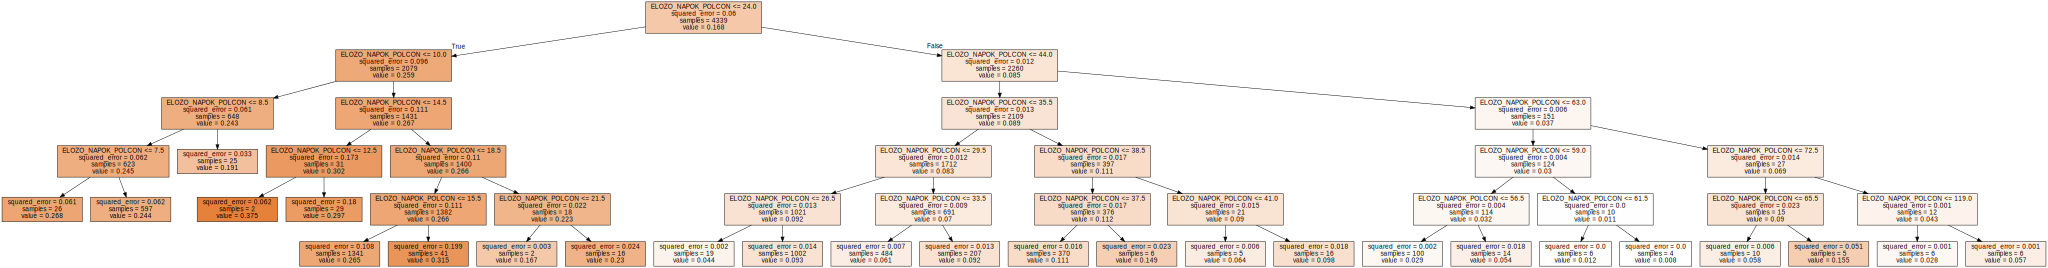

In [21]:
dot_data = tree.export_graphviz(
        dec_tree, out_file=None, feature_names=dec_tree.feature_names_in_, filled=True
    )
graphviz.Source(dot_data, format="png")

# lefuttatom a tesztadaton

In [22]:
testData = testData.reset_index()

In [23]:
test_preds = dec_tree.predict(testData.loc[:, x_colnames])

In [24]:
test_preds = pd.DataFrame(index=testData['index'], data={'pred': test_preds})

In [26]:
test_full = test_preds.join(target_test)

In [27]:
# ez stimmelt
mean_squared_error(test_full['y_true'], test_full['pred'], squared=False)

0.24213217046347218

In [26]:
my_preds= pd.DataFrame()
my_preds["LAPISSUGL-ARUSKOD"]=testData["index"]
my_preds["NAPI_ELADOTT_DB"]=test_preds
my_preds.to_csv('mypreds_NLili.csv', index=False) 